**Import section**

In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import ndcg_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pickle

In [3]:
from utils.train_eval_utils import train_eval
from utils.Encoder_model import make_Encoder_model
from utils.preprocess import Dataset_for_transformer, preprocess_data
from utils.loss_mask_utils import create_mask, Cross_Entropy_point, ListNet_Loss, Combined_Loss

**Preprocessing data and create dataloader**

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

file_path_train = r'/home/aletovv/Learning-To-Rank/Transformer/datasets/datas_full_10k_1.pkl'
file_path_test = r'/home/aletovv/Learning-To-Rank/Transformer/datasets/datas_full_10k_1.pkl'

train_data = preprocess_data(file_path_train, num_docs=850, which=0, is_shuffle=True, device = device)
val_data = preprocess_data(file_path_test, num_docs=850, which=-1, is_shuffle=True, device = device)

preprocess is done
preprocess is done


In [5]:
batch_size_train = 256
batch_size_test = 256

train_dataset = Dataset_for_transformer(train_data)
val_dataset = Dataset_for_transformer(val_data)


train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_test, shuffle=True)

In [6]:
print(train_dataset[0][0].shape[-1])

136


**Create model and parameters for training and evaluating**

In [7]:
input_dim = train_dataset[0][0].shape[-1]
output_dim = 5

model_parameters = {'d_model' : 512,
                    'n_heads' : 2,
                    'n_layers' : 2,
                    'ffn_hidden' : 512,
                    'input_dim' : input_dim,
                    'dropout_rate' : 0.15,
                    'device' : device,
                    'output_dim' : output_dim}

In [8]:
def get_model_and_params(model_params = model_parameters, optimizer = optim.AdamW, scheduler = None, initial_lr = 1e-3):
    model = make_Encoder_model(**model_params)
    opt = optimizer(model.parameters(), lr = initial_lr)
    scheduler = scheduler(opt) if scheduler != None else None
    
    return model, opt, scheduler

def get_train_params(model_params=model_parameters, optimizer=optim.AdamW, scheduler=None, initial_lr=1e-3, val_loader=val_loader,train_loader=train_loader,
                     loss_fn = Combined_Loss(), num_epochs = 25, create_mask=create_mask, score_fn=ndcg_score, name='best model'):
    model, optimizer, scheduler = get_model_and_params(model_params = model_params,
                                                       optimizer=optimizer, scheduler=scheduler, 
                                                       initial_lr=initial_lr)

    train_eval_parameters = {'train_loader' : train_loader,
                            'model' : model,
                            'optimizer' : optimizer,
                            'loss_fn' : loss_fn,
                            'num_epochs' : num_epochs,
                            'create_mask' : create_mask,
                            'val_loader' : val_loader,
                            'score_fn' : score_fn,
                            'scheduler' : scheduler,
                            'name' : name}
    return train_eval_parameters
    
    
    

**Training and Evaluate** 

In [9]:
def get_experiment_n_times(n_times,path_to_save, model_params=model_parameters, optimizer=optim.AdamW, scheduler=None, initial_lr=1e-3, val_loader=val_loader,train_loader=train_loader,
                            loss_fn = Combined_Loss(), num_epochs = 25, create_mask=create_mask, score_fn=ndcg_score, name='best model'):
    losses, metrics = {}, {}

    for i in range(n_times):
        train_params = get_train_params(model_params=model_params, optimizer=optimizer, scheduler=scheduler,initial_lr=initial_lr,
                                    val_loader=val_loader, train_loader=train_loader, loss_fn=loss_fn, num_epochs=num_epochs, create_mask=create_mask, score_fn=score_fn, name=name)
        loss, metric = train_eval(**train_params)
        losses[i] = loss
        metrics[i] = metric
        
        with open(path_to_save, 'wb') as f:
            pickle.dump(obj = [losses, metrics], file = f)
        
    return [losses, metrics]

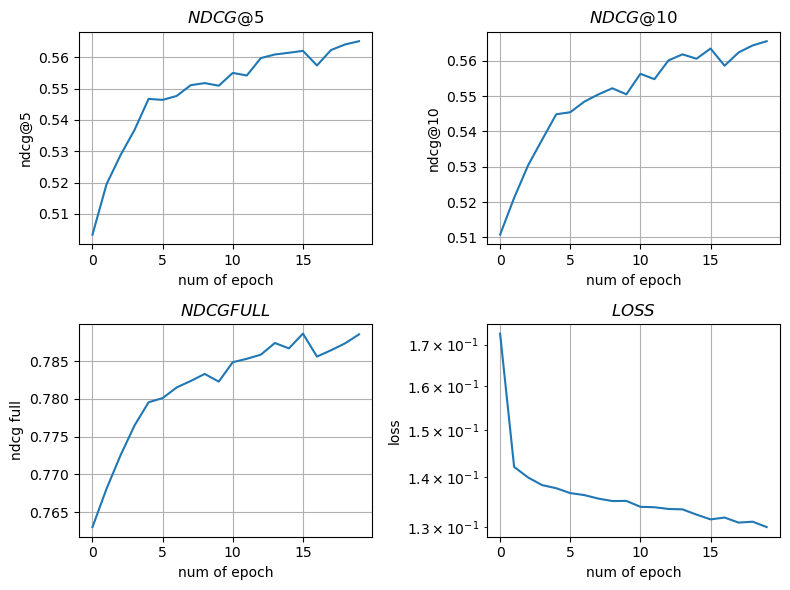

Epoch [20/20], Loss: 0.1300
NDCG@5 0.5652 || NDCG@10 0.5656 || Avg NDCG: 0.7885 
model saved on 20 epoch with best metric = 0.5652 


In [11]:
path_to_save = 'example.pkl'
n_times = 1
num_epochs = 20

losses, metrics = get_experiment_n_times(n_times=n_times,path_to_save=path_to_save, num_epochs=num_epochs, loss_fn=Cross_Entropy_point())